# Comparing methods for classifying word sense definitions
### M2 Computational linguistics - ML3 - Marie Candito

**NB: for this lab, work in groups of 2 students.**

Report to turn in on moodle by **January 5**.


## Task

The task is to classify word sense definitions into coarse semantic categories named "hypersenses".

In this lab, the objective is to explore several ways of using LLMs for this task.


## Data

We will use a dataset of manually labeled word senses, adapted from [(Barque et al., 2020)](https://aclanthology.org/2020.lrec-1.724/) by N. Angleraud in his M2 internship.

These word senses were labeled with a "supersense", each supersense corresponding to a broader "hypersense".

In [1]:
import pandas as pd
import gzip
import os

def download_and_load_tsv_gz(url):
  """Downloads a gzipped TSV file and loads it into a pandas DataFrame.
  Args:
    url: The URL of the gzipped TSV file.

  Returns:
    A pandas DataFrame containing the data from the file.
  """
  filename = url.split('/')[-1]
  if not os.path.exists(filename):
    !wget "$url"
  else:
    print(f"File '{filename}' already exists. Skipping download.")

  with gzip.open(filename, 'rt', encoding='utf-8') as f:
    df = pd.read_csv(f, sep='\t')

  return df


url = 'http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz'

try:
  df = download_and_load_tsv_gz(url)
  print("DataFrame loaded successfully.")
  print(df.head())  # Display the first few rows
except Exception as e:
  print(f"Error loading DataFrame: {e}")

--2024-11-22 10:26:26--  http://www.linguist.univ-paris-diderot.fr/~mcandito/divers/super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz
Resolving www.linguist.univ-paris-diderot.fr (www.linguist.univ-paris-diderot.fr)... 81.194.30.155
Connecting to www.linguist.univ-paris-diderot.fr (www.linguist.univ-paris-diderot.fr)|81.194.30.155|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 666342 (651K) [application/x-gzip]
Saving to: ‘super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz’

super_wiktionary_la 100%[===================>] 650.72K  1.38MB/s    in 0.5s    

2024-11-22 10:26:26 (1.38 MB/s) - ‘super_wiktionary_labeled_data_simplified.noex.25labels.tsv.gz’ saved [666342/666342]

DataFrame loaded successfully.
                    sense_id              entry_id         lemma  \
0      ws_1_esquerme__nom__1      esquerme__nom__1      esquerme   
1    ws_1_béruguette__nom__1    béruguette__nom__1    béruguette   
2  ws_2_agroécologie__nom__1  agro

### Distribution of supersenses

<Axes: xlabel='supersense'>

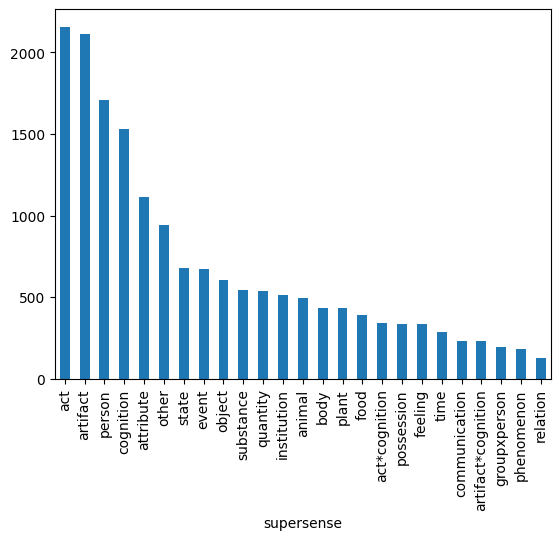

In [3]:
df['supersense'].value_counts().plot(kind='bar')

### Distribution of hypersenses

In [4]:
supersenses = df['supersense'].unique()
super2hyper = {'artifact': 'inanimate',
               'body': 'inanimate',
               'food': 'inanimate',
               'object': 'inanimate',
               'plant': 'inanimate',
               'substance': 'inanimate',
               'act':  'dynamic_situation',
               'event': 'dynamic_situation',
               'phenomenon': 'dynamic_situation',
               'animal': 'animate',
               'person': 'animate',
               'groupxperson': 'animate',
               'cognition': 'information',
               'communication': 'information',
               'quantity': 'quantity',
               'attribute': 'stative_situation',
               'feeling': 'stative_situation',
               'relation': 'stative_situation',
               'state': 'stative_situation',
               'time': 'time',
               'possession': 'possession',
               'institution': 'institution',
               'act*cognition': 'dynamic_situation*information',
               'artifact*cognition': 'inanimate*information',
               'other': 'other',
               }

<Axes: xlabel='hypersense'>

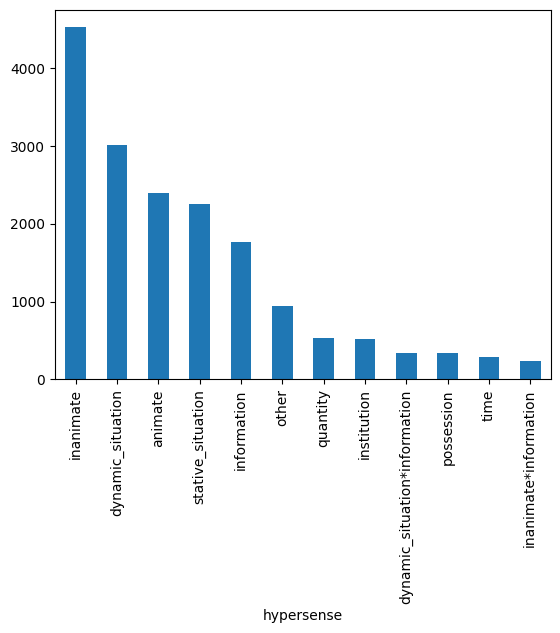

In [6]:
df['hypersense'] = df['supersense'].map(super2hyper)
df['hypersense'].value_counts().plot(kind='bar')

We can see that when we map each `supersense` with a `super2hyper`, we get a higher-level semantic category `hypersense`, and the final df in below:

In [7]:
df.head()

sense_id              entry_id         lemma  \
0      ws_1_esquerme__nom__1      esquerme__nom__1      esquerme   
1    ws_1_béruguette__nom__1    béruguette__nom__1    béruguette   
2  ws_2_agroécologie__nom__1  agroécologie__nom__1  agroécologie   
3     ws_1_webcaméra__nom__1     webcaméra__nom__1     webcaméra   
4     ws_1_Reguinois__nom__1     Reguinois__nom__1     Reguinois   

   nb_occ_lemma_frsemcor supersense        set  \
0                      0      plant  rand-test   
1                      0       food   rand-dev   
2                      0        act  rand-test   
3                      0   artifact  rand-test   
4                      0     person   rand-dev   

                                          definition         hypersense  
0                                   Plante potagère.          inanimate  
1            Variété d’olive allongée à pulpe ferme.          inanimate  
2  Pratique ou mode de production agricole appliq...  dynamic_situation  
3                                Synonyme de webcam.          inanimate  
4  Habitant de Réguiny, commune française située ...            animate

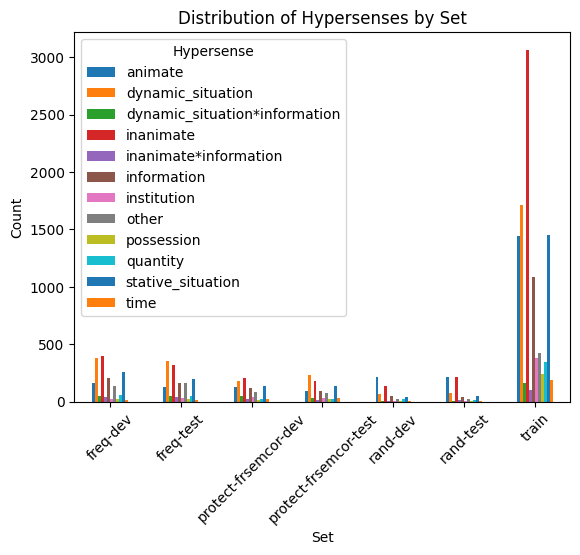

In [9]:
import matplotlib.pyplot as plt

# PB: note the distribution in the training set, dev and test sets are quite different

df.groupby('set')['hypersense'].value_counts().unstack().plot(kind='bar')
plt.title('Distribution of Hypersenses by Set')
plt.xlabel('Set')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Hypersense')
plt.show()

## Classifiers

You will compare
1. using a causal model with in-context learning (e.g. with N=4,8,16 examples)
  - you will use a small LLM (maximum 7B), fine-tuned for instructions
    - either use a mini model (< 2G) on google colab
    - or a quantized version of a little larger model (< 7B)
      - the bitsandbytes module on huggingface can help you : https://huggingface.co/docs/transformers/main/quantization/bitsandbytes
      - there are also some pre-quantized models by unsloth.ai (faster to download, and you save the time to quantize) : https://huggingface.co/unsloth/mistral-7b-bnb-4bit
    - https://llm.extractum.io/static/llm-leaderboards/
    - explain how you chose the model
    - a possible leaderboard for evaluation in languages other than English:
      - https://huggingface.co/spaces/openGPT-X/european-llm-leaderboard
  - or use the huggingface API to run the model on HF's servers
    - cf. https://huggingface.co/docs/huggingface_hub/guides/inference
    - (I don't know the exact amount of inference you can do with the free version)
  - Look for prompts tested in the literature to perform text classification, and adapt it to (1) French, and to (2) the type of texts in this lab, namely word sense definitions.

2. parameter-efficient fine-tuning on the full training set
  - see the numerous examples on the web for using LoRA or QLoRA in a google colab

3. optional: Flaubert (a bert for french) full fine-tuning

## Methodology

The dataset comprises a training set (cf. column "set" of the dataframe), and several dev and test sets.

In all your work you will ignore the "protect-frsemcor" instances.
You will use rand-dev for tuning hyperparameters (including the form of prompts, the nb of demonstrations in ICL etc...), and report your FINAL results on freq-test and rand-test, for the two main methods (ICL and LoRA fine-tuning).



## How your project will be evaluated

You will turn in a PDF file, with a report on your methodology, experiments, problems encountered, results etc...
- you should point to your colab within the pdf report
- or the pdf can be directly created from google colab, with your code and execution traces, in which case, write down in the colab the link to itself.

It is likely that you will use code seen on the web or generated via gemini, so you need to show me you perfectly master your code : write a lot of comments.

The overall performance is not what matters most, in particular because it would be a waste of compute energy to make too many experiments.

You project will be evaluated based on
- sound methodology
- clear and commented code
- well presented and discussed results
- error analysis (trying to figure out what kind of instances are badly classified and why?)

Since in this project we will ignore the "protect-frsemcor" instances, so we can filter out instances of protect-frsemcor first. Then we will use `training set` to train the model, a `rand-dev` for tuning hyperparameters, and `freq-test` for evaluating the model's performance on high-frequency words, a `rand-test` to evaluate the performance of the model on random words. So we can prepare each dataset in advance.

In [16]:
df = df[~df['set'].str.contains('protect-frsemcor')]
# check if the 'set' column containing the 'protect-frsemcor'
df['set'].unique()

array(['rand-test', 'rand-dev', 'freq-dev', 'freq-test', 'train'],
      dtype=object)

In [ ]:
train_df = df[df['set'] == 'train']
rand_dev_df = df[df['set'] == 'rand-dev']
freq_test_df = df[df['set'] == 'freq-test']
rand_test_df = df[df['set'] == 'rand-test']